## Acknowledgement
This is an adaptation of Thomas Wiecki's [tutorial on Bayesian Neural Nets](http://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/). 

## Bayesian Inference
When it comes to prediction however, we need one more step. Consider Bayesian linear regression with weights $w$. With the bayes rule we can get the posterior:
\begin{align}
p(w|x,y) \propto p(y|w,x) p (w)
\end{align}

Once we wish to use the above model, we can do the following:
\begin{align}
p(y_*|x_*, x,y) &= \int p(y_*|x_*,w) p(w|x,y) dw \\
&\approx \frac{1}{N_{trace}}\sum_j p(y_*|x_*,w_j)
\end{align}
where $w_j$ were the sampled weights via the `trace` function.

## Variational Inference
Let us denote the dataset $\mathcal{D} = \{x,y\}$. Bayesian inference wishes to maximise the log likelihood of the data. The log likelihood can be wriiten as:
\begin{align}
\log p(\mathcal{D}) = \int q(w) \log \frac{p(\mathcal{D}, w)}{q(w)} dw - \int q(w) \log \frac{p(w|\mathcal{D})}{q(w)} dw
\end{align}
The first integral turns out to be a lower bound of the log likelihood and is maximised when $q(w) = p(w|\mathcal{D})$.

Therefore we replace $q(w)$ with some parametrised form, eg. Gaussian with its own parameters $\mu,\sigma$ and maximise the first integral term.

In [1]:
%%capture
%%bash
pip install pymc3==3.8
pip install arviz==0.6.1
pip install Theano==1.0.4

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
import theano.tensor as tt

%matplotlib inline

In [3]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [5]:
x_train = x_train.reshape((len(x_train), -1))
x_test = x_test.reshape((len(x_test), -1))
n_out = 10 # 10 digits

\begin{align}
w &\sim \mathcal{N}(0,1) \\
\mu &= w^T x \\
p_j &= \frac{\exp(\mu_j)}{\sum_k\exp(\mu_k)} \\
p(y_i) &= p_1^{y_{i1}}p_2^{y_{i2}}...p_T^{y_{iT}}
\end{align}

In [9]:
with pm.Model() as linear_model:
    ann_input = pm.Data('ann_input', x_train)
    ann_output = pm.Data('ann_output', y_train)
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, shape=(x_train.shape[1], n_out))

    mu = pm.math.dot(ann_input,weights_in_1)
    p = tt.nnet.softmax(mu)
    # multinomial logistic function
    y = pm.Categorical('y', p=p, observed=ann_output, total_size=len(y_train)) #

/usr/local/lib/python3.7/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.7/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [11]:
x_train.shape, (x_train.shape[1], n_out), y_train[:,None].shape

((60000, 784), (784, 10), (60000, 1))

In [12]:
with linear_model:
    approx = pm.fit(n=1000)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 4.2561e+05: 100%|██████████| 1000/1000 [05:21<00:00,  3.11it/s]
Finished [100%]: Average Loss = 4.2496e+05


In [13]:
plt.plot(approx.hist)

In [14]:
trace = approx.sample(1000)
print(trace.varnames)

['w_in_1']


In [15]:
trace['w_in_1'].shape

(1000, 784, 10)

In [16]:
with linear_model:
    test_probs = approx.sample_node(p, more_replacements={ann_input: x_test}, size=500)
test_prob_out = test_probs.eval()
print(test_prob_out.shape)
mean_test_prob = test_prob_out.mean(axis=0)
test_pred = mean_test_prob.argmax(axis=-1)
print('Test Accuracy: {:.4f}'.format((test_pred == y_test).sum()/len(y_test)))

(500, 10000, 10)
Test Accuracy: 0.8257


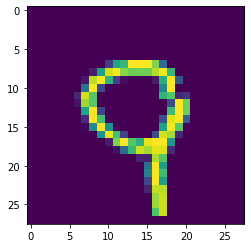

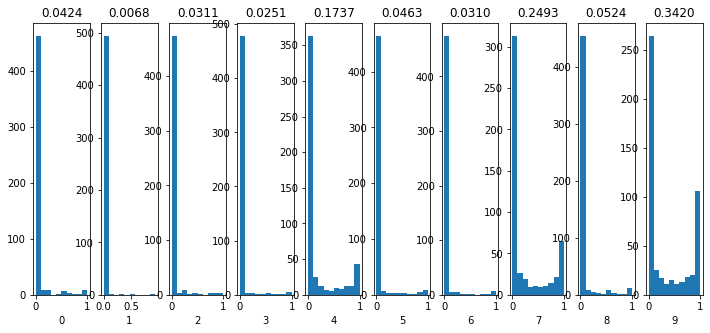

In [18]:
np.random.seed(1)
idx = np.random.randint(0,len(y_test))
plt.imshow(x_test[idx].reshape(28,28))
plt.show()

plt.figure(figsize=(12,5))
samples = test_prob_out[:,idx,:]
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.hist(samples[:,i])
    sample_mean = samples[:,i].mean()
    plt.title(f"{sample_mean:.4f}")
    plt.xlabel(i)
plt.show()

## Minibatch Variational Inference

In [21]:
x_train.dtype, y_train.astype(float).dtype, x_train.shape, y_train.shape

(dtype('float64'), dtype('float64'), (60000, 784), (60000,))

In [22]:
minibatch_x = pm.Minibatch(x_train, batch_size=256)
minibatch_y = pm.Minibatch(y_train.astype(float), batch_size=256)
with linear_model:
    approx = pm.fit(more_replacements={ann_input: minibatch_x, ann_output: minibatch_y})
  
plt.plot(approx.hist)
plt.show()

/usr/local/lib/python3.7/dist-packages/pymc3/data.py:246: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])
  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 353.37: 100%|██████████| 10000/10000 [00:44<00:00, 223.92it/s]
Finished [100%]: Average Loss = 352.91


In [23]:
with linear_model:
    test_probs = approx.sample_node(p, more_replacements={ann_input: x_test}, size=500)
test_prob_out = test_probs.eval()
print(test_prob_out.shape)
mean_test_prob = test_prob_out.mean(axis=0)
test_pred = mean_test_prob.argmax(axis=-1)
print('Test Accuracy: {:.4f}'.format((test_pred == y_test).sum()/len(y_test)))

(500, 10000, 10)
Test Accuracy: 0.9106


In [27]:
test_prob_out[0].sum(axis=-1)

array([1., 1., 1., ..., 1., 1., 1.])

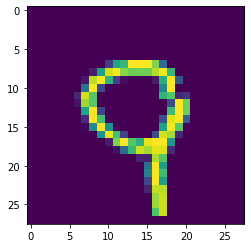

In [29]:
np.random.seed(1)
idx = np.random.randint(0,len(y_test))
plt.imshow(x_test[idx].reshape(28,28))
plt.show()

plt.figure(figsize=(12,5))
samples = test_prob_out[:,idx,:]
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.hist(samples[:,i])
  mean_samples = samples[:,i].mean()
  plt.title(f"{mean_samples:.4f}")
  plt.xlabel(i)
plt.show()

## Deep Bayesian Network
\begin{align}
w &\sim \mathcal{N}(0,1) \\
\mu &= w_3^Tr(w_2^Tr(w_1^T x)) \\
p_j &= \frac{\exp(\mu_j)}{\sum_k\exp(\mu_k)} \\
p(y_i) &= p_1^{y_{i1}}p_2^{y_{i2}}...p_T^{y_{iT}}
\end{align}
where $r$ is the relu function, $r(x) = \max(0,x)$.

In [32]:
ann_input = theano.shared(x_train)
ann_output = theano.shared(y_train)
n_hidden = 40

with pm.Model() as dnn:
  # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=0.1,
                           shape=(x_train.shape[1], n_hidden))

    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=0.1,
                          shape=(n_hidden, n_hidden))

    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1,
                            shape=(n_hidden,n_out))

    # Build neural-network using relu activation function
    act_1 = tt.nnet.relu(pm.math.dot(ann_input,
                                   weights_in_1))
    act_2 = tt.nnet.relu(pm.math.dot(act_1,
                                   weights_1_2))
    mu = pm.math.dot(act_2, weights_2_out)
    p = tt.nnet.softmax(mu)
    # multinomial logistic function
    y = pm.Categorical('y', p=p, observed=ann_output, total_size=len(y_train))

/usr/local/lib/python3.7/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [33]:
minibatch_x = pm.Minibatch(x_train, batch_size=128)
minibatch_y = pm.Minibatch(y_train, batch_size=128)
with dnn:
    approx = pm.fit(n=75000, more_replacements={ann_input: minibatch_x, ann_output: minibatch_y})
    
plt.plot(approx.hist)
plt.show()

/usr/local/lib/python3.7/dist-packages/pymc3/data.py:246: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])
  0%|          | 0/75000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 64.141: 100%|██████████| 75000/75000 [13:43<00:00, 91.08it/s]
Finished [100%]: Average Loss = 64.125


In [34]:
with dnn:
    test_probs = approx.sample_node(p, more_replacements={ann_input: x_test}, size=500)
test_prob_out = test_probs.eval()
print(test_prob_out.shape)
mean_test_prob = test_prob_out.mean(axis=0)
test_pred = mean_test_prob.argmax(axis=-1)
print('Test Accuracy: {:.4f}'.format((test_pred == y_test).sum()/len(y_test)))

(500, 10000, 10)
Test Accuracy: 0.9447


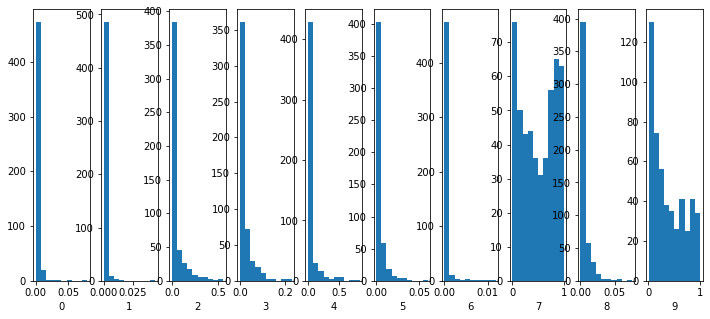

Most likely Bayesian estimate: 7


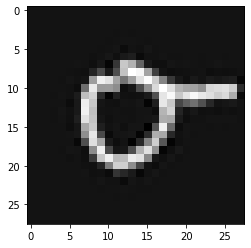

In [ ]:
from scipy.ndimage import rotate

img = x_test[idx].reshape(28,28)
rotate_img = img
for i in range(5):
    rotate_img = rotate(rotate_img, 45, reshape=False)

    plt.imshow(rotate_img, cmap='gray')
    plt.show()

    with dnn:
        test_probs = approx.sample_node(p, more_replacements={ann_input: rotate_img.ravel()[None]}, size=500)
    test_prob_out = test_probs.eval()
    test_prob_out.shape

    plt.figure(figsize=(12,5))
    samples = test_prob_out.squeeze()
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.hist(samples[:,i])
        plt.xlabel(i)
    plt.show()

    print('Most likely Bayesian estimate: {:d}'.format(np.argmax(test_prob_out.squeeze().mean(axis=0))))

## Other Reads
- Bayesian Methods for Hackers: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers
- PyMC3 examples: https://docs.pymc.io/examples
- Quantile Regression: https://towardsdatascience.com/deep-quantile-regression-c85481548b5a